### Benchmarking Performance of Trend Filtering for Extrapolation in Simulations and Real Data

Methods
- Trend Filtering (TF)
- Linear Regression (LR)
- Linear Splines (LS)
- Kernel Smoothers (KS)

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

# simulation imports
from simulations.generate_sims import generate_samples, generate_true_dgp
from prior_models.uniform_prior import Uniform_Prior
from prior_models.kernel_smooth import Kernel_Smooth_Prior

# trend filtering imports
from matrix_algorithms.difference_matrix import Difference_Matrix
from trend_filtering.adaptive_tf import adaptive_tf
from continous_tf import Continous_TF
from trend_filtering.cv_tf import cross_validation

### Generate Data (Simulations)

Simulations consist of true functions that are piecewise linear with noisy samples

True changepoints: [ 26  81 206 274]


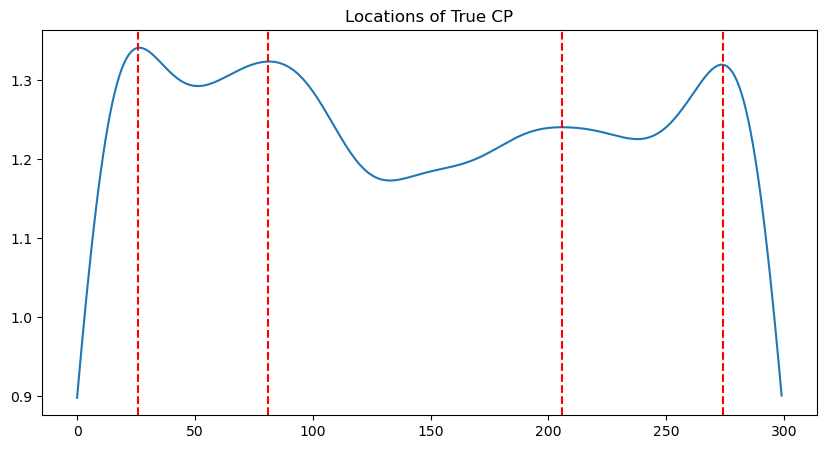

In [2]:
n=300

# generate prior for changepoint locations
prior = Kernel_Smooth_Prior(Uniform_Prior(n))

# generate true data
true, true_knots, cp_knots = generate_true_dgp(prior, "piecewise_linear", label_style="k_local_spikes")

print(f"True changepoints: {true_knots}")

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title("Locations of True CP")
ax.plot(prior.prior)
for i in true_knots:
    ax.axvline(i, color='r', linestyle='--')

### Let's Draw Some Samples

In [3]:
adjusted_true,samples=generate_samples(true, prior.t, true_knots, snr=5)

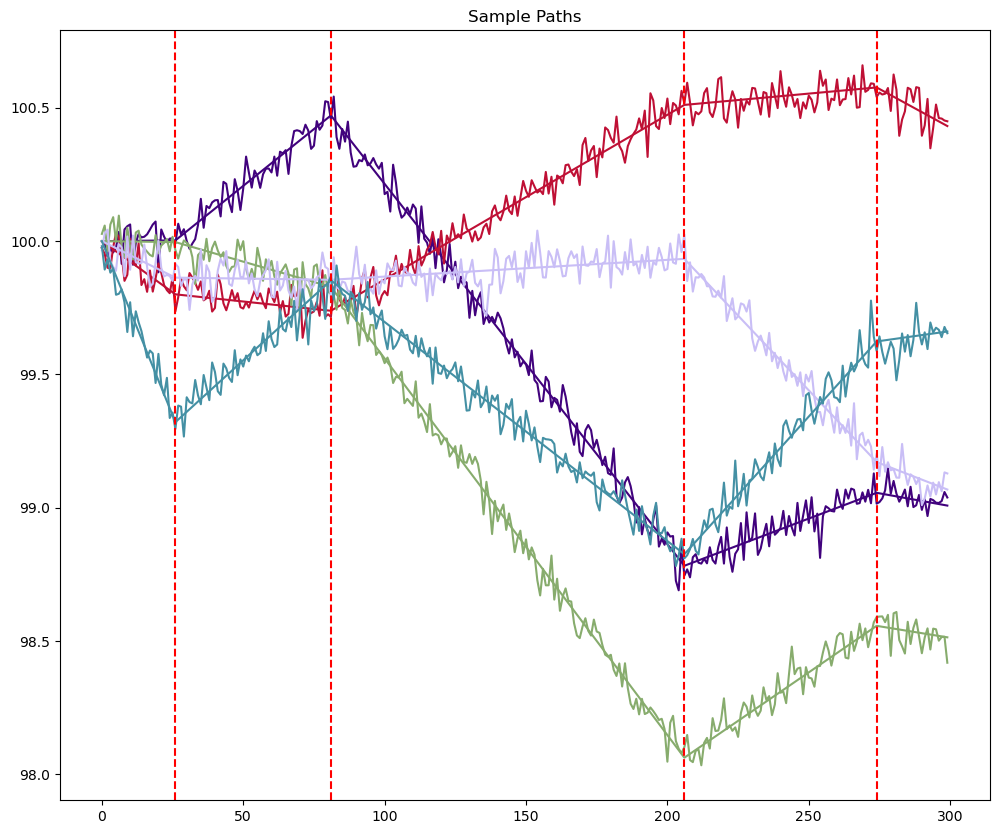

In [4]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
ax.set_title("Sample Paths")
n_samples = samples.shape[0]



for i in range(n_samples):
    random_color = np.random.rand(3,)
    ax.plot(samples[i,:], color=random_color)
    ax.plot(adjusted_true[i,:], color=random_color)

for i in true_knots:
    ax.axvline(i, color='r', linestyle='--')


### Train Each Method on first 250 observations

Again recall the methods are:
- Trend Filtering (TF)
- Linear Regression (LR)
- Linear Splines (LS)
- Kernel Smoothers (KS)


### Trend Filtering

Best lambda: 2.529188921935145
{0: [0, 26], 1: [26, 81], 2: [81, 206], 3: [206, 250], 4: [250, 274]}
eff_param 3 fixed_mse 0.021023961312095732 true_mse inf
eff_param 4 fixed_mse 0.0011206218579849314 true_mse inf
eff_param 5 fixed_mse 0.0009529985202931947 true_mse inf
eff_param 6 fixed_mse 0.0009485106269266194 true_mse inf
eff_param 7 fixed_mse 0.0009485106269200553 true_mse inf
eff_param 2 fixed_mse 0.07185784748033153 true_mse inf
Estimated changepoints: [7, 89, 204]
True changepoints: [ 26  81 206 274]
Best lambda: 0.15409170744180373
{0: [0, 26], 1: [26, 81], 2: [81, 206], 3: [206, 250], 4: [250, 274]}
eff_param 3 fixed_mse 0.0027624562195175456 true_mse inf
eff_param 4 fixed_mse 0.0007568929648223614 true_mse inf
eff_param 5 fixed_mse 0.00037763456955421326 true_mse inf
eff_param 6 fixed_mse 0.000290312018599884 true_mse inf
eff_param 7 fixed_mse 0.00023156776411231413 true_mse inf
eff_param 2 fixed_mse 0.013198972806990027 true_mse inf
Estimated changepoints: [7, 24, 81, 207, 

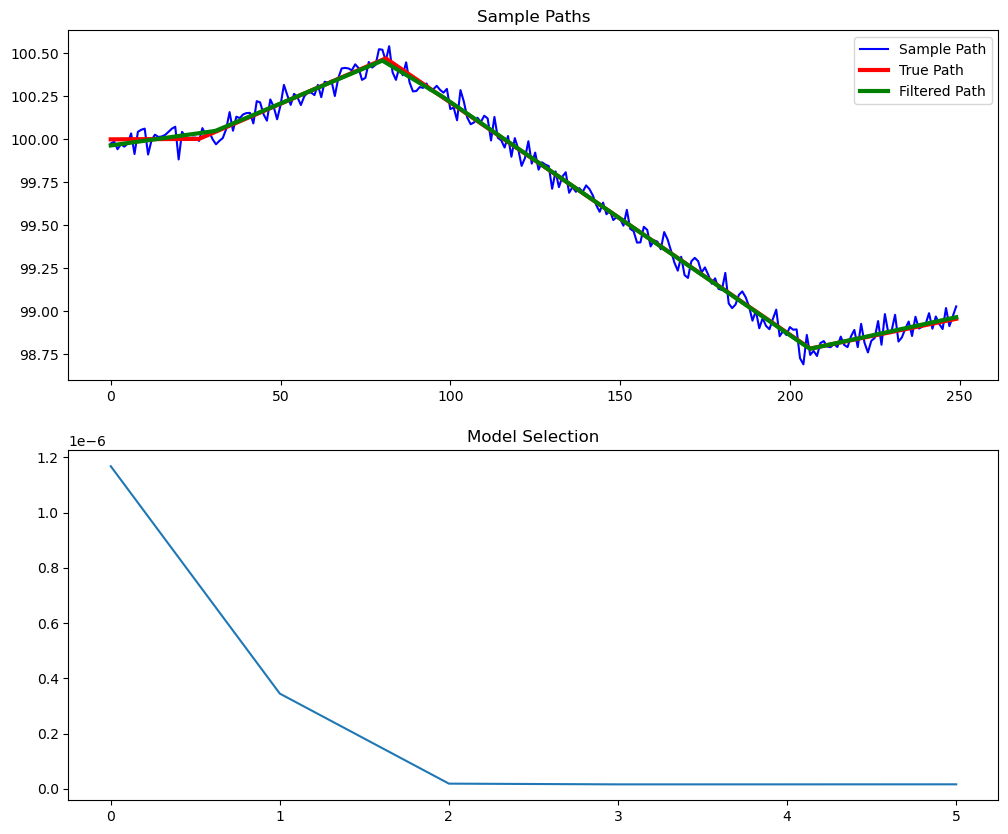

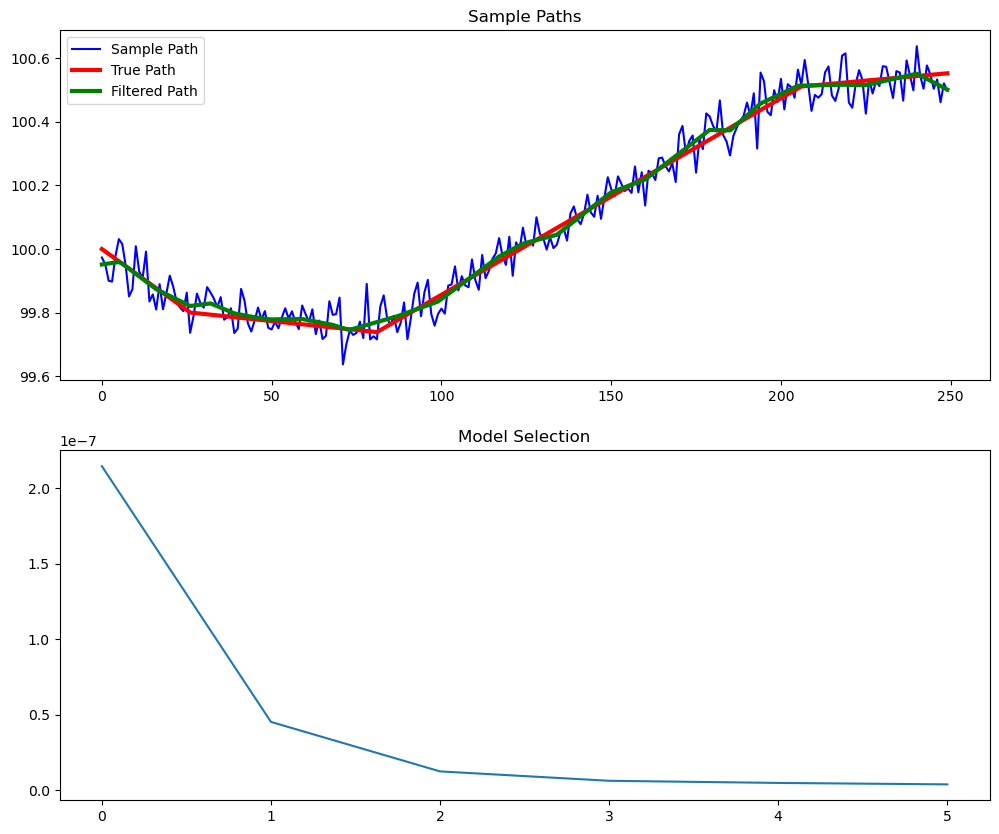

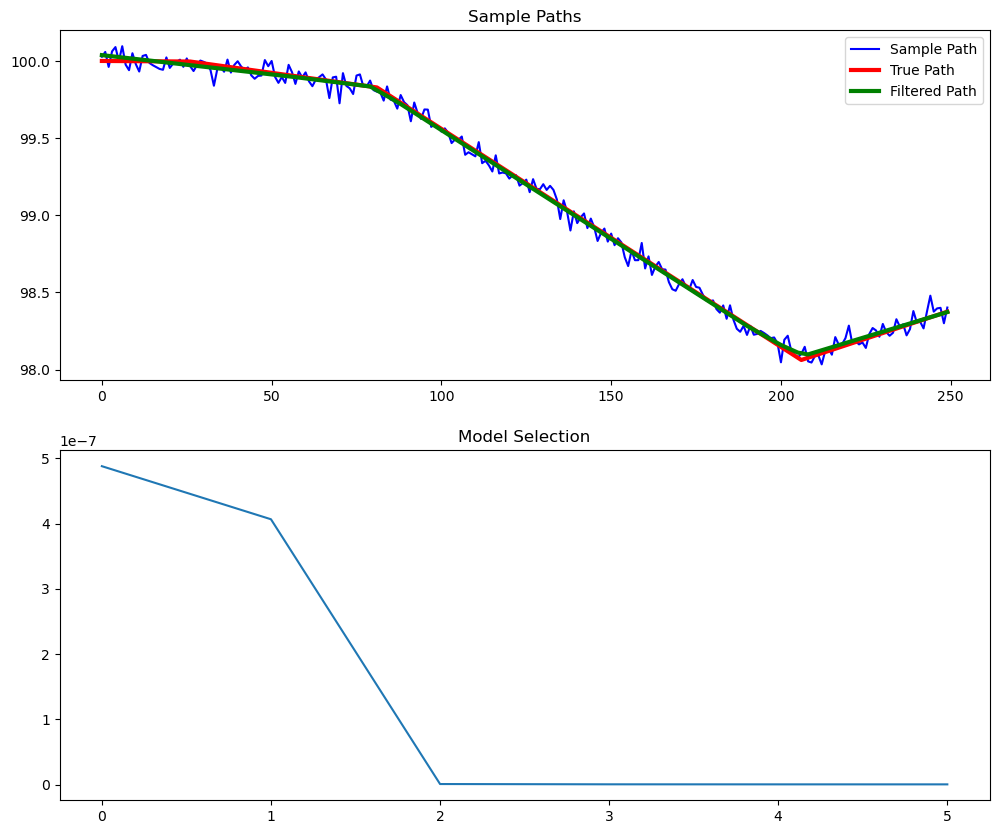

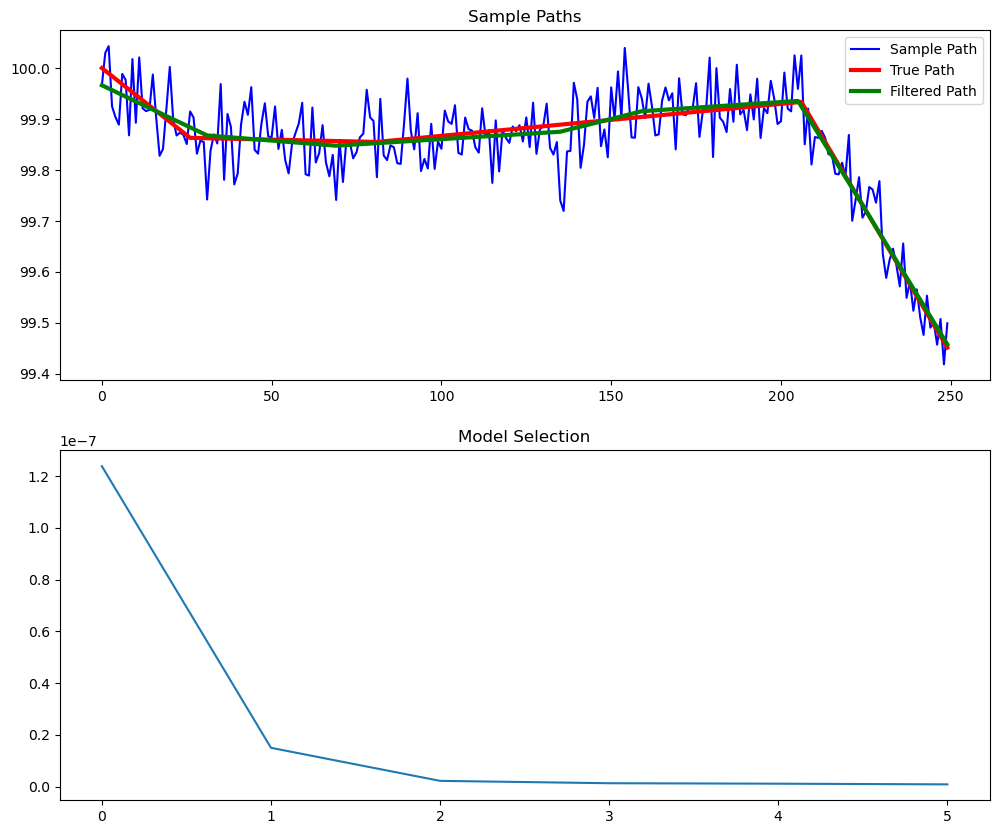

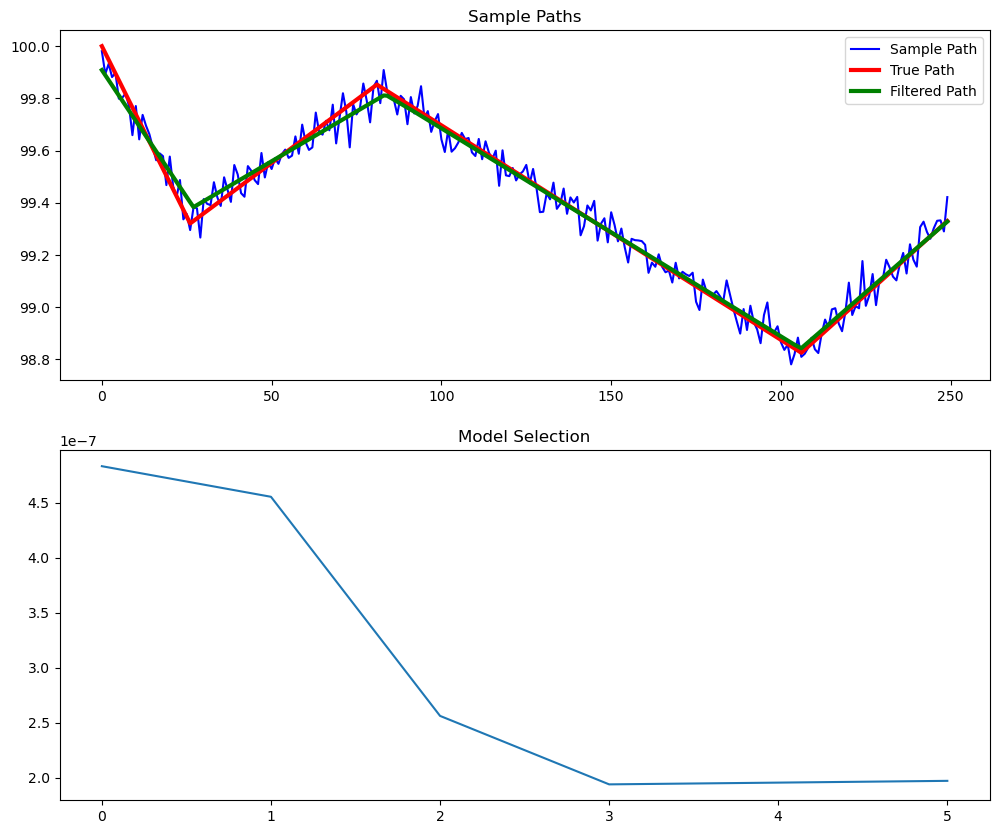

In [5]:
k=250


for k_sample in range(samples.shape[0]):

    D=Difference_Matrix(250,k=1)
    best_lambda=cross_validation(samples[k_sample,:k].reshape(-1,1), D,cv_folds=15,cv_iterations=3,verbose=False)

    print(f"Best lambda: {best_lambda}")

    results=adaptive_tf(samples[k_sample,:k].reshape(-1,1), D, best_lambda,select_knots=True,true_knots=true_knots)
    sorted_gcvs=sorted(results['sol'].gcv_scores, key=lambda x: x[0])

    print(f"Estimated changepoints: {results['sol'].knots}")
    print(f"True changepoints: {true_knots}")
    #print(f"MSE: {results['mse']}")

    fig, ax = plt.subplots(2,1, figsize=(12,10))
    ax[0].set_title("Sample Paths")
    ax[0].plot(samples[k_sample,:k], color='b', label="Sample Path")
    ax[0].plot(adjusted_true[k_sample,:k], color='r', label="True Path",lw=3)
    ax[0].plot(results['sol'].x, color='g', label="Filtered Path",lw=3)
    ax[0].legend()

    ax[1].set_title("Model Selection")
    ax[1].plot([i[0] for i in sorted_gcvs], [i[1] for i in sorted_gcvs], label="GCV")
    



  
